# Loading Data, Preprocessing,Data Split and Feature Extraction

**Loading files and making a dataframe**

In [ ]:
!unzip Data.zip -d Data >/dev/null

In [ ]:
'''Reading and processing files'''
import glob
import os
import xml.etree.ElementTree as et
'''Dataframe'''
import pandas as pd
'''Plotting'''
import matplotlib.pyplot as plt
'''Text preprocessing'''
import nltk
import string
from sklearn.preprocessing import MultiLabelBinarizer
'''Feature Extraction'''
from gensim import models
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
'''Machine Learning'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.model_selection import GridSearchCV
from sklearn import cluster
from sklearn.preprocessing import Normalizer
'''Autoencoder'''
from tensorflow.python.keras.layers import Input, Dense, Lambda,Reshape,Layer
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import initializers,regularizers
from tensorflow.python.keras.losses import mse,mean_squared_error
import tensorflow as tf
from tensorflow.python.keras import metrics
#https://stackoverflow.com/questions/54430310/keras-out-of-memory-with-small-batch-size
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())
'''Ignoring warnings'''
import warnings
warnings.filterwarnings(action='ignore')

The following GPU devices are available: /device:GPU:0


In [ ]:
files = glob.glob("." + '/**/*.xml', recursive=True)

In [ ]:
def createDFFromXMLFiles():
  rows = []
  for file in files:
    xTree = et.parse(file)
    xRoot = xTree.getroot()
    headline = xRoot.find("headline").text
    itemid = xRoot.attrib.get("itemid")
    codes = xRoot.findall(".//codes[@class='bip:topics:1.0']")
    biptopics = []
    for node in codes:
        for code in node:
            biptopics.append(code.attrib.get("code"))
    dcdatepublished = xRoot.find(".//dc[@element='dc.date.published']").attrib.get("value")
    text = ""
    for n in xRoot.find("text"):
        text = text + (" " + n.text if n.text else "")
  
    if len(biptopics)>=1:
      rows.append({"headline": headline, "text": text,
                 "biptopics": biptopics, "dc.date.published": dcdatepublished, "itemid": itemid, "XMLfilename":
                     os.path.basename(file)})
  
  global newsItemsDF
  newsItemsDF = pd.DataFrame(rows, columns=df_cols)
  
  #display first few rows and all their columns
  pd.set_option('display.expand_frame_repr', False)
  print(newsItemsDF.loc[0:5,])

newsItemsDF = None  
df_cols = ["headline", "text", "biptopics", "dc.date.published", "itemid", "XMLfilename"]
createDFFromXMLFiles()

                                            headline                                               text                           biptopics dc.date.published  itemid       XMLfilename
0        PRESS DIGEST - Saudi newspapers - March 10.   These are some of the leading stories in the ...                              [GCAT]        1997-03-10  431988  431988newsML.xml
1             BA marketing executive joins Eurostar.   British Airways Plc confirmed on Sunday that ...                   [C41, C411, CCAT]        1997-03-10  431610  431610newsML.xml
2             RESEARCH ALERT - Wal-Mart said raised.   -- Smith Barney upgraded Wal-Mart Stores Inc ...                   [C15, C152, CCAT]        1997-03-10  430935  430935newsML.xml
3  FINNISH EMU OPPONENTS OUTNUMBER SUPPORTERS - P...   Finns opposed to membership of European econo...  [E12, ECAT, G15, G154, GCAT, GPOL]        1997-03-10  431541  431541newsML.xml
4     U.S. tribes cite pressure to give more to DNC.   Two small Native American

**Preprocessing**

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# resource:https://machinelearningmastery.com/clean-text-machine-learning-python/

def textPreprocessing():
  num_of_words_in_documents=0;
  for index in range(len(newsItemsDF['text'])):
    text = newsItemsDF['text'][index]
    # step 1: tokenize
    tokens = nltk.tokenize.word_tokenize(text)
    # step 2: convert to lower case
    tokens = [w.lower() for w in tokens]
    # step 3: remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # step 4: only keep letters
    words = [word for word in stripped if word.isalpha()]
    # step 5: filter out stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # step 6: lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer() 
    words = [lemmatizer.lemmatize(w) for w in words] 
    # step 7: concat clean words and make a clean text
    text = ''
    for word in words:
        text = text + " " + word
    newsItemsDF.at[index, 'text'] = text
    num_of_words_in_documents=num_of_words_in_documents+len(words)
  print(newsItemsDF.loc[0:5])
  print('Average number of words in a document = '+str(num_of_words_in_documents/newsItemsDF.shape[0]))
textPreprocessing()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
                                            headline                                               text                           biptopics dc.date.published  itemid       XMLfilename
0        PRESS DIGEST - Saudi newspapers - March 10.   leading story saudi arabian press monday reut...                              [GCAT]        1997-03-10  431988  431988newsML.xml
1             BA marketing executive joins Eurostar.   british airway plc confirmed sunday top marke...                   [C41, C411, CCAT]        1997-03-10  431610  431610newsML.xml
2             RESEARCH ALERT - Wal-Mart said raised.   smith barney upgraded walmart store inc buy o...                   [C

In [ ]:
newsItemsDF.to_pickle('news.pkl')

In [ ]:
newsItemsDF = pd.read_pickle('news.pkl')

**Spliting dataframe into train and test sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(newsItemsDF["text"], newsItemsDF["biptopics"], test_size=0.3,
                                                  shuffle = True)

**Two versions for "y"s, one for multi-class classification, and for multi-labeled one**

In [ ]:
def getMulticlassY(series):
  y = []
  for index, topics in series.iteritems():
    y.append(topics[0])#only take the first topic of the list
  return pd.DataFrame(y)

mlb = MultiLabelBinarizer().fit(newsItemsDF["biptopics"])
def getMultilabelY(series):
  return pd.DataFrame(mlb.transform(series), columns=mlb.classes_, index=series.index)

y_train_multiclass=getMulticlassY(y_train)
y_test_multiclass=getMulticlassY(y_test)
y_train_multilabel=getMultilabelY(y_train)
y_test_multilabel=getMultilabelY(y_test)

**Using Word2Vec and TF-IDF to create numeric presentation of text**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/glove.6B.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
embeddings_dict = {}
with open("/tmp/glove.6B.50d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

**Making a feature vector per document with Glove**
<br>
Due to lack of memory, advanced hardware and the fact that taking more words per each document would result in more feature, thus more time required for processing, I decided to take only the average number of words per document. In the "preprocessing" part, this number was found to be around 130. Therefore, I took the first 130 words per document, extracted their embedding vector, concatenated the vectors into a 130*50 vector for each document. 

In [ ]:
nltk.download('punkt')
average_words_per_doc= 130
embedding_size=50
def vectorize_docs(documents):
    num_features = embedding_size*average_words_per_doc
    x = np.zeros(shape=(len(documents), num_features)).astype(np.float32)
    for idx, words in enumerate(documents):
        words = nltk.tokenize.word_tokenize(words)
        for jdx, word in enumerate(words):
          if jdx>=average_words_per_doc:
            break #if the number of words in this document is more than the average, do not continue
            '''if this word is availabe in Glove, put its embedding vector 
                in documents feature vector'''
          if word in embeddings_dict:
            x[idx, jdx*embedding_size:((jdx+1)*embedding_size)] = embeddings_dict[word]
    return pd.DataFrame(x)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVectorizer = TfidfVectorizer(max_features=3000)
def learnVocabulary(trainSet):
  tfidfVectorizer.fit(trainSet)
def getTFIDFScores(documents):
  return pd.DataFrame(tfidfVectorizer.transform(documents).toarray())
learnVocabulary(X_train)

# Clustering
**Choosing an algorithm**<br>
Requirements for this project:
1. be scalable for large samples
2. be able to find a cluster most similar to a new sample it hasn’t seen during fitting

looking at different clustering algorithms implemented by [Scikit](https://scikit-learn.org/stable/modules/clustering.html), I decided to choose K-Means. Because it is scalabe for large number of samples, and it has a "predict" fuction for predicting which cluster does an unseen instance belong to. I also tried to use DBSCAN and its other version, Optics but they both labeled many instances as outlier. It needed extensive search for choosing best hyper-parameters, but K-Means doesn't need much tuning. DBSCAN also doesn't have the ability to find which cluster a new unseen sample belongs to. Heirarchical algorithms like Agglomerative where much slower that K-Means so it was unefficient to call them in each CV fold for clustering the train set. Also, similar to DBSCAN, they can't find a similar cluster for a new instance that they had not seen during fitting.<br>
**Number of clusters**<br>
I initially tried to use Elbow method for finding the optimal number of clusters to use. Even though there was an elbow found using Glove vectors at k=6, but the size of the clusters were very uneven and not enough samples were in each cluster for training the autoencoders. Since I used 6500 features per document using Glove, I decided to have 4 clusters so with around 32K training set, each cluster would have almost enought samples for training autoencoders.<br>
**Evaluation**<br>
Since I decided to use K-Means and there was not another algorithm that was equally fast and also able to predict unseen data, the evaluation of clustering is not between algorithms but between two ways of representing text with numbers. In this project I used both word embedding and TF-IDF for text representation and did all the train and test flow on both representations to compare them at last. I also wanted to see how K-Means would cluster the data using each method. <br>
Since we don't have any ground truth about what cluster each document belongs to, we cannot use external evaluation metrics. I used all three internal evaluatiom metrics implemented by Scikit and it turns out K-Means clusters points better when there are represented with TF-IDF. The Silhouette Coefficient and Calinski-Harabasz Index are higher, and Davies-Bouldin Index is lower (when using Davies-Bouldin Index, lower index means better partitioning). Later, we'll see that with TF-IDF, we get the highest accuracy and weighted f1. Thus, the final results also confirm that clusters with TF-IDF have more similarity within themselves.

In [ ]:
X_train_w2v = vectorize_docs(X_train)
X_test_w2v = vectorize_docs(X_test)
transformer = Normalizer().fit(X_train_w2v)
embeddings_dict=None

In [ ]:
X_train_tfidf = getTFIDFScores(X_train)
X_test_tfidf = getTFIDFScores(X_test)

In [ ]:
kmeans = cluster.KMeans(n_clusters=4)
we = kmeans.fit(X_train_w2v)
tfidf = kmeans.fit(X_train_tfidf)

**Question 3: Function for evaluating the clusters**

In [ ]:
def evaluate_clusters(data,labels):
  return {'silhouette':silhouette_score(data,labels, metric='euclidean'),
          'calinski':calinski_harabasz_score(data,labels) ,
          'davis':davies_bouldin_score(data,labels)}
silhouette={}
calinski={}
davis={}
we_results = evaluate_clusters(X_train_w2v,we.labels_)
tfidf_results = evaluate_clusters(X_train_tfidf,tfidf.labels_)
silhouette['w2v']=we_results['silhouette']
silhouette['tfidf']=tfidf_results['silhouette']
calinski['w2v']=we_results['calinski'] 
calinski['tfidf']=tfidf_results['calinski'] 
davis['w2v']=we_results['davis']
davis['tfidf']=tfidf_results['davis']

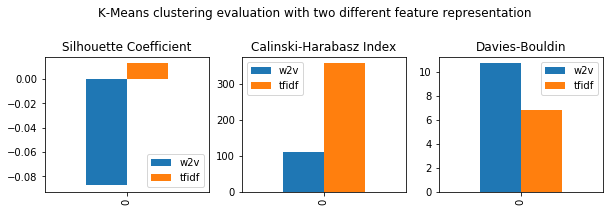

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
pd.DataFrame(silhouette, index=[0]).plot(kind='bar',figsize=(10,3),title='Silhouette Coefficient',ax=axes[0])
pd.DataFrame(calinski, index=[0]).plot(kind='bar',title='Calinski-Harabasz Index',ax=axes[1])
pd.DataFrame(davis, index=[0]).plot(kind='bar',title='Davies-Bouldin',ax=axes[2])
fig.suptitle('K-Means clustering evaluation with two different feature representation')
plt.subplots_adjust(top=0.75)

The negative value of Silhouette Coefficient for w2v clustering means that the clusters are overlapped. We can see that in the visualization of the clusters found with each method. (For visualizing w2v representation I normalized the data before using PCA otherwise becasue the vectors have values that are outside [0,1] range and PCA would give higher preference to larger values)

Text(0.5, 1.0, 'K-Means with TF-IDF')

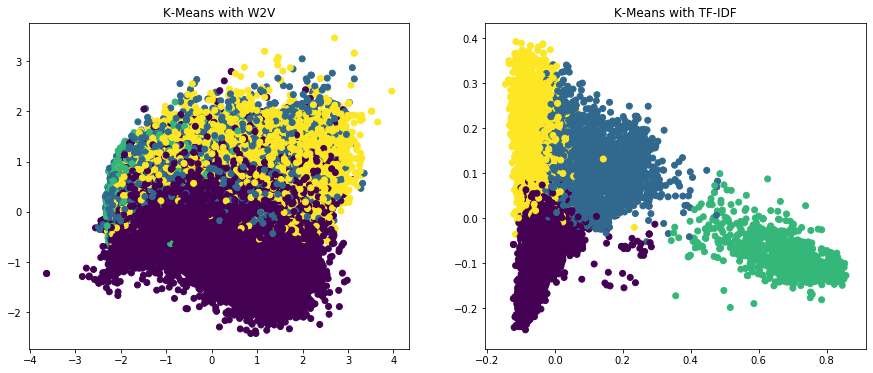

In [ ]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
pca = PCA(n_components=2,random_state=42)
twoD = pca.fit_transform(MinMaxScaler().fit_transform(X_train_w2v))
plt.scatter(twoD[:,0], twoD[:,1], c=we.labels_.astype(float))
plt.title('K-Means with W2V')
plt.subplot(1,2,2)
twoD = pca.fit_transform(X_train_tfidf)
plt.scatter(twoD[:,0], twoD[:,1], c=tfidf.labels_.astype(float))
plt.title('K-Means with TF-IDF')

# Training a classifier for each cluster

**Question 2: Function for assigning cluster ids to documents, generating a classifier for each cluster**<br>
The function "getTrainTestDFsForEachCluster" clusters the train set and also predicts a cluster for each instance in test set. Then it will return a dictionary where the keys are cluster ids, and values are a set of dataframes for x train, y train, x test, and y test for each cluster. This makes it easier to manage in CV loop.<br>
The function "trainClassifier" receives the x and y dataframes extracted by "getTrainTestDFsForEachCluster" and trains a NN classifier for that cluster. The function has a grid search which will tune the parameters for that specific cluster. I chose NN classifier because in the first assignment is outperformed the other classifiers. The number of hidden units is also the square root of the feaures. Both autoencoders will extract features of size 750, so the square root is based on 750, not the 6500 features without feature extraction.

In [ ]:
num_of_clusters = 4
def getTrainTestDFsForEachCluster(x_train,y_train,x_test,y_test):
  kmeans = cluster.KMeans(n_clusters=num_of_clusters).fit(x_train)
  cluster_labels = pd.Series(kmeans.labels_, name='cluster')
  cluster_prediction_labels = pd.Series(kmeans.predict(x_test), name='cluster')
  x_train.reset_index(drop=True, inplace=True)
  y_train.reset_index(drop=True, inplace=True)
  x_test.reset_index(drop=True, inplace=True)
  y_test.reset_index(drop=True, inplace=True)
  tempX = pd.concat([x_train, cluster_labels], axis=1)
  tempY = pd.concat([y_train, cluster_labels], axis=1)
  tmpX = pd.concat([x_test, cluster_prediction_labels], axis=1)
  tmpY = pd.concat([y_test, cluster_prediction_labels], axis=1)
  clusters={}
  for cluster_id in range(num_of_clusters):
    x = tempX.loc[tempX['cluster']==cluster_id].drop('cluster',axis=1)
    y = tempY.loc[tempY['cluster']==cluster_id].drop('cluster',axis=1)
    xtest = tmpX.loc[tmpX['cluster']==cluster_id].drop('cluster',axis=1)
    ytest = tmpY.loc[tmpY['cluster']==cluster_id].drop('cluster',axis=1)
    clusters[cluster_id]={'x_train':x,'y_train':y,'x_test':xtest,'y_test':ytest}
  return clusters

In [ ]:
def trainClassifier(x,y): 
    cv=3
    if x.shape[0]<3:
        cv=2
    gridsearch = GridSearchCV(estimator = MLPClassifier(hidden_layer_sizes=(27,)),
                        param_grid =dict(activation=['relu','tanh','logistic']),
                        cv =cv,verbose=0,n_jobs=-1,scoring='f1_macro',refit='f1_macro')
    gridSearchResult = gridsearch.fit(x, y)
    return gridSearchResult.best_estimator_

# Testing the model

1. **Find the nearest cluster for each test sample**
2. **Use that cluster's classifer to predict the label** 

There is two ways of testing the model. One way is major voting. That is have each classifier make a prediction about the topic of a document and then use the most predicted topic as the final prediction. But since the documents within each cluster are similar to each other and different from other clusters, if one classifer predicts a good enough answer but other classifiers predict a false topic becasue they have not seen enough samples of this document, then the major vote will be the wrong answer instead of the correct one. <br>
Second way is finding the nearest cluster to each test instance and use the classifier trained on that cluster for prediction. This is what [this paper](https://ieeexplore.ieee.org/document/5346902) has done to improve performance and reduce training time for multi-label classification with large number of labels.<br>
The function "classifyAndEvaluat" gets the list of classifiers trained on each cluster and their x and y for testing. The x and y for test come from predictions of K-Means for test set, and also each x has been compacted with an AE trained for that particular cluster. Predictions of each classifier is combined into one final set of predictions for the entire test set and the results are evaluated. The metrics are accuracy and weighted-f1. I used the weighted averaging to give more weight to topics that are more common in dataset, because as we saw in assignment one this dataset is highly imbalanced and some topics are very rare. So the weighted f1 will give less importance to misclassified rare topics. Change from assignment 1: in the previous assignment I used f1-macro giving equal importance to all topics, but here I thought it would be fine if a rare class is misclassified, and the focus should be on common ones.


In [ ]:
def classifyAndEvaluate(classifiers,xtests,ytest):
    tmpDf = None
    tmpYDf = None
    counter = 0
    for classifier in classifiers:
      predictions = None
      if len(xtests[counter])!=0:
          xtest = pd.DataFrame(xtests[counter])
          predictions = classifier.predict(xtest)
      if tmpDf is None:
          tmpDf = pd.DataFrame(predictions)
          tmpYDf = pd.DataFrame(ytest[counter])
      else:
          tmpDf = pd.concat([tmpDf, pd.DataFrame(predictions)],ignore_index=True)
          tmpYDf = pd.concat([tmpYDf, pd.DataFrame(ytest[counter])],ignore_index=True)
      counter = counter + 1
    predictions = tmpDf

    return {"f1_weighted":f1_score(tmpYDf, predictions, average='weighted'),
           "accuracy":accuracy_score(tmpYDf,predictions)}
  

# Feature Extraction with Relational Autoencoder

**Question 4: Feature extraction with Autoencoders**
<br>
I used [paper no. 2](https://ieeexplore.ieee.org/abstract/document/7965877), for feature extraction. This paper used two different datasets and a number of different autoencoders. RVAE and RDAE were the two AE that outperformed the others in each of the datasets. Therefore, I used both of them to comapre the results and see which one performs better with this dataset.<br>
Both of the autoencoders have equal number of hidden layers, 7, so the results would be comparable. I also used L1 regularization to prevent them from overfitting. I had initially used L2, but the results specially with TF-IDF were not desirable. I think it is because the feature vectors are sparse and L2 regularization doesn't make any feature exactly zero, so the reconstruction that was supposed to be sparse as well, was significantly different from the input. For making the DAE and VAE relational, I used the alpha and t that the paper found works best.
<br>I used the following sources for implementing the autoencoders. I had to make some changes to make them relational accourding to the paper. Sources:[one](http://www.stokastik.in/understanding-variational-autoencoders/), [two](https://github.com/ser-art/RAE-vs-AE/blob/master/AE_vs_RAE.ipynb), [three](https://github.com/Toni-Antonova/VAE-Text-Generation/blob/master/vae_nlp.ipynb)


In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch, dim = K.shape(z_mean)[0], K.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1)
    return z_mean + z_log_var * epsilon

In [ ]:
original_dim=None
regulizer = regularizers.l1(0.001)

def L(X, X_):
  return mean_squared_error(X, X_)

def R(X):
  return K.dot(X, K.transpose(X))

def tau(X):
  return tf.where(X < 1, X, tf.zeros(tf.shape(X)))

def relational_variational_autoencoder(X_train):
    m = np.prod(X_train.shape[1])
    global original_dim
    original_dim=m
    input_document = Input(shape=(X_train.shape[1],))
    
    #Encoder
    encoded = Dense(units=m, activation='relu')(input_document)
    encoded = Dense(units=2000, activation='relu',activity_regularizer=regulizer)(encoded)
    encoded = Dense(units=1500, activation='relu',activity_regularizer=regulizer)(encoded)
    encoded = Dense(units=1000, activation='relu',activity_regularizer=regulizer)(encoded)
    z_mean, z_sigma = Dense(750)(encoded), Dense(750)(encoded)
    z = Lambda(sampling, output_shape=(750,))([z_mean, z_sigma])
    encoder = Model(input_document,z)
    
    #Decoder
    decoded = Dense(units=1000, activation='relu',activity_regularizer=regulizer)(z)
    decoded = Dense(units=1500, activation='relu',activity_regularizer=regulizer)(decoded)
    decoded = Dense(units=2000, activation='relu',activity_regularizer=regulizer)(decoded)
    decoded = Dense(m, activation='sigmoid')(decoded)
    
  
    # Compute VAE loss
    def vae_loss(y_true, y_pred):
      alpha=0.4
      xent_loss = original_dim * metrics.mean_squared_error(y_true, y_pred)
      kl_loss = - 0.5 * K.sum(1 + z_sigma- K.square(z_mean) - K.exp(z_sigma), axis=-1)
      xent_loss_relation = original_dim * metrics.mean_squared_error(tau(R(y_true)),tau(R(y_pred)))
      return (1-alpha)*K.mean(xent_loss + kl_loss)+alpha*K.mean(xent_loss_relation + kl_loss)
    
    autoencoder = Model(input_document,decoded)
    autoencoder.compile(optimizer='adagrad',loss=vae_loss)
    h = autoencoder.fit(X_train,X_train, shuffle=True, epochs=10,verbose=0,validation_split=0.2,batch_size=32)
    history = h.history
    
    return encoder, autoencoder,history

In [ ]:
def rae_loss(alpha,corrupted_input):
  def rae(y_true, y_pred):
    return (1 - alpha)*L(y_true, y_pred) + alpha*L(tau(R(y_true)), tau(R(corrupted_input)))
  return rae

def relational_denoising_autoencoder(X_train):
    m = np.prod(X_train.shape[1])
    global original_dim
    original_dim=m
    noisy_input = Input(shape=(X_train.shape[1],))
    
    #Encode
    encoded = Dense(m, activation='relu')(noisy_input)
    encoded = Dense(units=2000, activation='relu',activity_regularizer=regulizer)(encoded)
    encoded = Dense(units=1500, activation='relu',activity_regularizer=regulizer)(encoded)
    encoded = Dense(units=1000, activation='relu',activity_regularizer=regulizer)(encoded)
    encoded = Dense(units=750, activation='relu',activity_regularizer=regulizer)(encoded)
    encoder = Model(noisy_input,encoded)
    
    #Decoder
    decoded = Dense(1000, activation='relu',activity_regularizer=regulizer)(encoded)
    decoded = Dense(1500, activation='relu',activity_regularizer=regulizer)(decoded)
    decoded = Dense(2000, activation='relu',activity_regularizer=regulizer)(decoded)
    decoded = Dense(m, activation='sigmoid')(decoded)

    #Full Autoencoder
    autoencoder = Model(noisy_input, decoded)
    loss = rae_loss(0.4,noisy_input)
    autoencoder.compile(optimizer='adagrad',loss=loss)
    corrupted_X_train = X_train * np.random.choice([0,1], X_train.shape, p=[0.1,0.9])
    h = autoencoder.fit(corrupted_X_train,X_train, shuffle=True, epochs=10,verbose=0,validation_split=0.2,batch_size=32)
    history = h.history
    
    return encoder, autoencoder,history

In [ ]:
def extractFeatures(x_train,x_test,AE='variational',normalizeData=False):
  histories = {}
  encoder, autoencoder,history,test_features=None,None,None,None
  if normalizeData:
    x_train = transformer.transform(x_train)
    x_test = transformer.transform(x_test)
  if AE=='variational':
    encoder, autoencoder,history = relational_variational_autoencoder(x_train)
  elif AE=='denoising':
    encoder, autoencoder,history = relational_denoising_autoencoder(x_train)
  train_features = encoder.predict(x_train)
  if x_test.shape[0]!=0:#the number of samples for train and test for this cluster is lower than 3
    test_features = encoder.predict(x_test)
  #clear memory to prevent crash!
  del encoder
  del autoencoder
  K.clear_session()
  tf.reset_default_graph()
  history['size']=x_train.shape[0]
  return train_features,test_features,history

In [ ]:
def plotAELossEpoch(num_of_clusters,histories):
  plt.figure(figsize=(15, 3))
  subplotCounter=1
  for i in range(num_of_clusters):
    if i in histories:
      plt.subplot(1, len(histories), subplotCounter)
      plt.plot(histories[i]['loss'])
      plt.plot(histories[i]['val_loss'])
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.title('cluster '+str(i)+' (size='+str(histories[i]['size'])+')')
      plt.legend(['train','test'], loc='upper right')
      subplotCounter=subplotCounter+1
  plt.tight_layout()
  plt.show()

In [ ]:
def trainTestFlow(clusters,autoencoder,normalizeData):
  histories={} 
  classifiers = []
  test_features_for_each_classifier=[]
  y_tests=[] 
  for cluster_id,dfs in clusters.items():

    if(dfs['x_test'].shape[0]==0):
      continue
    train_features,test_features,history = extractFeatures(dfs['x_train'],dfs['x_test'],
                                                           autoencoder,normalizeData)
    test_features_for_each_classifier.append(test_features)
    histories[cluster_id]=history
    classifiers.append(trainClassifier(train_features,dfs['y_train']))
    y_tests.append(dfs['y_test'])
  plotAELossEpoch(num_of_clusters,histories)
  result = classifyAndEvaluate(classifiers,test_features_for_each_classifier,y_tests)
  return result

#Cross Validation
<br>
The function "cross_validation" does a three-fold cross validation on train set. After the corss validation and reporting the reuslts of each fold, I did the clustering, feature extraction and training classifiers on the entire dataset with the best autoencoder found from CV. This way the AEs would have more data to train compared to CV where only a percentage of the train set is used. <br>
The following is experimented in each fold:

1. classification without clustering with feature extraction with both of the AEs
2. classification with clustering and feature extraction with both of the AEs

The following combinations is experimented (CV, training on entire train set and final testing on test set):
1. Multi-class classification with TF-IDF
1. Multi-class classification with Word Embedding
1. Multi-label classification with TF-IDF
1. Multi-label classification with Word Embedding



In [ ]:
def cross_validation(X_train,Y_test,normalize=False):
  skf = KFold(n_splits=3,random_state=42,shuffle=True)
  fold_counter = 1;
  clusters = {}
  classifiers = None
  #X_train = pd.DataFrame(X_train)
  accuracies={'without clustering(RVAE)':[],'without clustering(RDAE)':[],
            'with clustering(RVAE)':[],'with clustering(RDAE)':[]}
  f1s={'without clustering(RVAE)':[],'without clustering(RDAE)':[],
            'with clustering(RVAE)':[],'with clustering(RDAE)':[]}
  for train_index, test_index in skf.split(X_train, Y_test):
    print('Fold #'+str(fold_counter))
    X_train_cv = X_train.iloc[train_index].copy()
    X_test_cv = X_train.iloc[test_index].copy()
    y_train_cv = Y_test.iloc[train_index].copy()
    y_test_cv = Y_test.iloc[test_index].copy()
    print('without clustering')
    train_features,test_features,history = extractFeatures(X_train_cv,X_test_cv,'variational')
    classifiers=[trainClassifier(train_features,y_train_cv)]
    result = classifyAndEvaluate(classifiers,[test_features],[y_test_cv])
    accuracies['without clustering(RVAE)'].append(result['accuracy'])
    f1s['without clustering(RVAE)'].append(result['f1_weighted'])
    print('Relationa VAE results:'+str(result))
    train_features,test_features,history = extractFeatures(X_train_cv,X_test_cv,'denoising')
    classifiers=[trainClassifier(train_features,y_train_cv)]
    result = classifyAndEvaluate(classifiers,[test_features],[y_test_cv])
    accuracies['without clustering(RDAE)'].append(result['accuracy'])
    f1s['without clustering(RDAE)'].append(result['f1_weighted'])
    print('Relational DAE results:'+str(result))
    print('with clustering')
    clusters = getTrainTestDFsForEachCluster(X_train_cv,y_train_cv,X_test_cv,y_test_cv)
    result = trainTestFlow(clusters,'variational',normalize)
    accuracies['with clustering(RVAE)'].append(result['accuracy'])
    f1s['with clustering(RVAE)'].append(result['f1_weighted'])
    print('Relationa VAE results:'+str(result))
    result = trainTestFlow(clusters,'denoising',normalize)
    accuracies['with clustering(RDAE)'].append(result['accuracy'])
    f1s['with clustering(RDAE)'].append(result['f1_weighted'])
    print('Relational DAE results:'+str(result))
    fold_counter = fold_counter + 1
  return accuracies, f1s
  
def plotCVResults(accuracies,f1s,subtitle):
  plt.figure(figsize=(15, 5))
  plt.subplot(1,2,1)
  legends = []
  for key,val in accuracies.items():
    plt.plot(range(1,4),val)
    plt.ylabel('accuracy')
    plt.xlabel('fold')
    legends.append(key)
  plt.legend(legends, loc='best')
  plt.subplot(1,2,2)
  for key,val in f1s.items():
    plt.plot(range(1,4),val)
    plt.ylabel('f1-weighted')
    plt.xlabel('fold')
    legends.append(key)
  plt.legend(legends, loc='best')
  plt.suptitle(subtitle, fontsize=15)
  plt.show()


**Multi-class classification with Word Embedding**

Fold #1
without clustering
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Relationa VAE results:{'f1_weighted': 0.3977294910153309, 'accuracy': 0.4413854351687389}
Relational DAE results:{'f1_weighted': 0.07501071933846666, 'accuracy': 0.2133214920071048}
with clustering


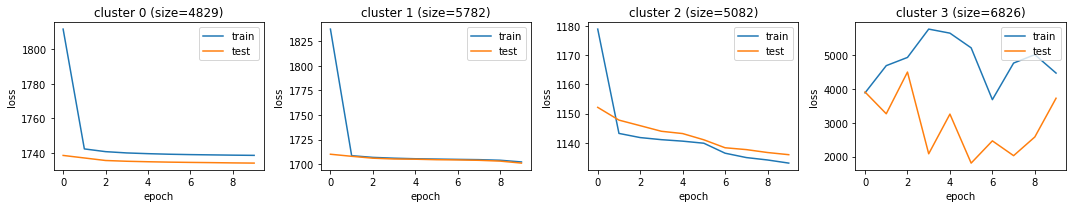

Relationa VAE results:{'f1_weighted': 0.38955773510683733, 'accuracy': 0.4318827708703375}


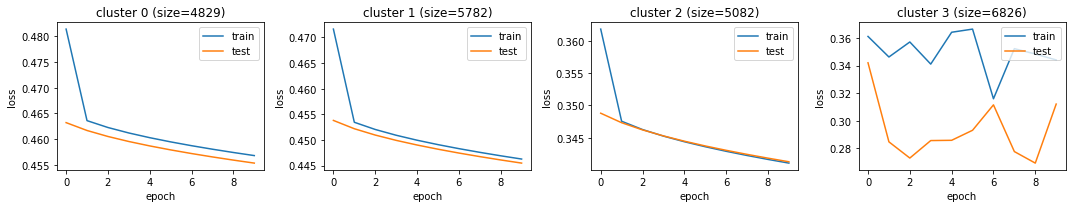

Relational DAE results:{'f1_weighted': 0.2029283832366496, 'accuracy': 0.31198934280639434}
Fold #2
without clustering
Relationa VAE results:{'f1_weighted': 0.4041935569857818, 'accuracy': 0.44591474245115453}
Relational DAE results:{'f1_weighted': 0.08097125112665725, 'accuracy': 0.22246891651865008}
with clustering


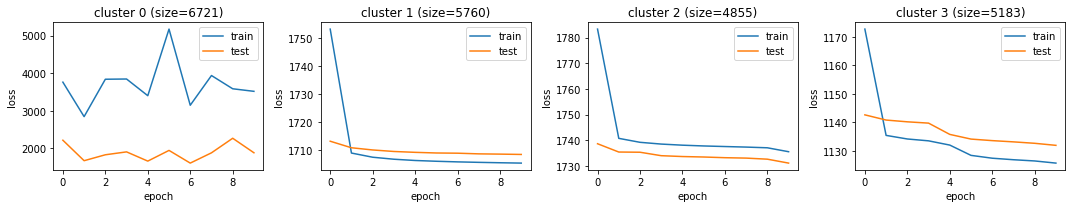

Relationa VAE results:{'f1_weighted': 0.37687141872543334, 'accuracy': 0.4183836589698046}


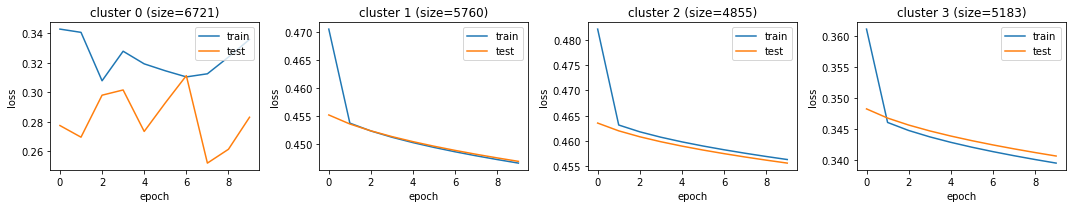

Relational DAE results:{'f1_weighted': 0.20914426992512816, 'accuracy': 0.31376554174067495}
Fold #3
without clustering
Relationa VAE results:{'f1_weighted': 0.4082654795506806, 'accuracy': 0.45661248778754776}
Relational DAE results:{'f1_weighted': 0.07388690616306895, 'accuracy': 0.21156408206767918}
with clustering


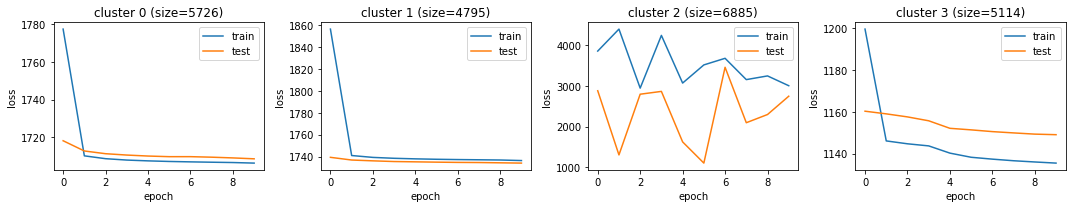

Relationa VAE results:{'f1_weighted': 0.37770342110375443, 'accuracy': 0.41602273736566303}


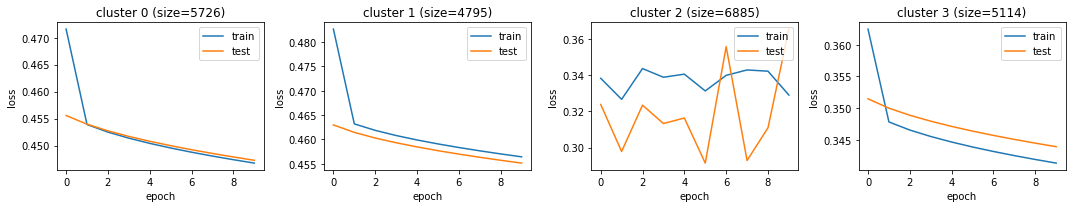

Relational DAE results:{'f1_weighted': 0.20063213393534907, 'accuracy': 0.3089084288125056}


In [ ]:
accuracies,f1s = cross_validation(X_train_w2v,y_train_multiclass,False)

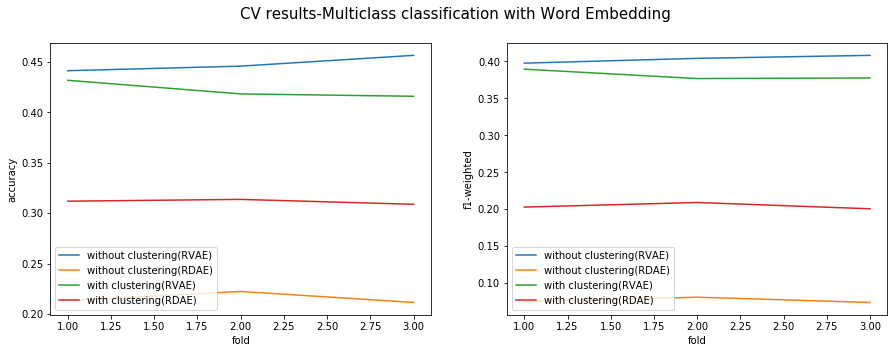

In [ ]:
plotCVResults(accuracies,f1s,'CV results-Multiclass classification with Word Embedding')

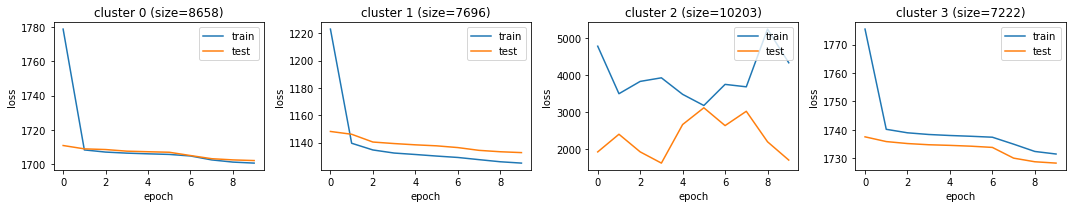

{'f1_weighted': 0.4128983106622703, 'accuracy': 0.451512639867385}


In [ ]:
clusters = getTrainTestDFsForEachCluster(X_train_w2v,y_train_multiclass,X_test_w2v,y_test_multiclass)
test_result = trainTestFlow(clusters,'variational',False)
print(test_result)

**Multi-class classification with TF-IDF**

Fold #1
without clustering
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Relationa VAE results:{'f1_weighted': 0.4235006743893604, 'accuracy': 0.47602131438721135}
Relational DAE results:{'f1_weighted': 0.07828637909567016, 'accuracy': 0.2183836589698046}
with clustering


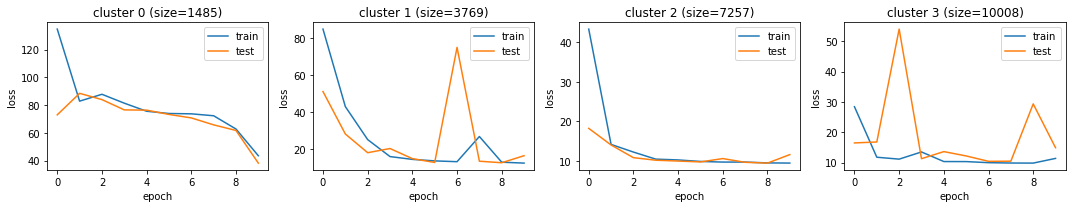

Relationa VAE results:{'f1_weighted': 0.4265874386680311, 'accuracy': 0.48206039076376556}


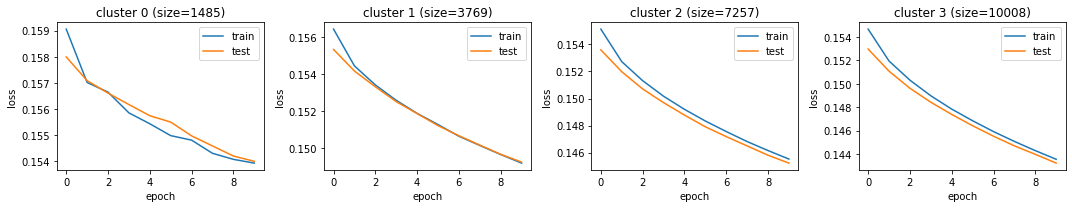

Relational DAE results:{'f1_weighted': 0.26504212253230675, 'accuracy': 0.4043516873889876}
Fold #2
without clustering
Relationa VAE results:{'f1_weighted': 0.43422607505679167, 'accuracy': 0.47975133214920074}
Relational DAE results:{'f1_weighted': 0.0731404680256172, 'accuracy': 0.21039076376554175}
with clustering


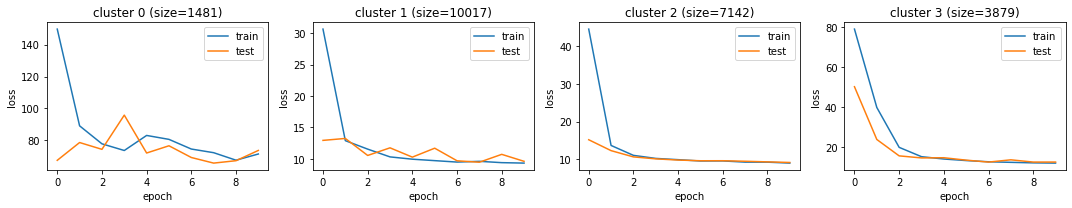

Relationa VAE results:{'f1_weighted': 0.4440255175355641, 'accuracy': 0.4997335701598579}


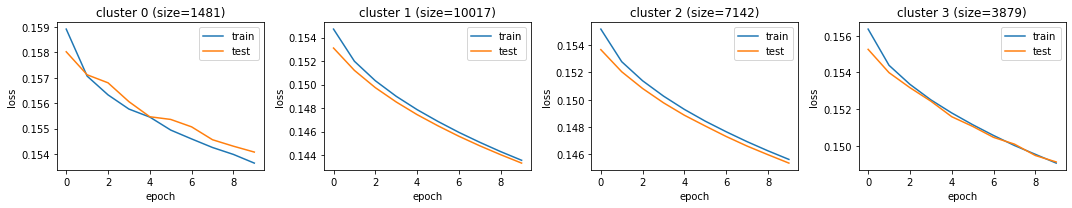

Relational DAE results:{'f1_weighted': 0.25122457480641824, 'accuracy': 0.3910301953818828}
Fold #3
without clustering
Relationa VAE results:{'f1_weighted': 0.43657790589341317, 'accuracy': 0.4811262101429967}
Relational DAE results:{'f1_weighted': 0.07547923992440485, 'accuracy': 0.21405098143707257}
with clustering


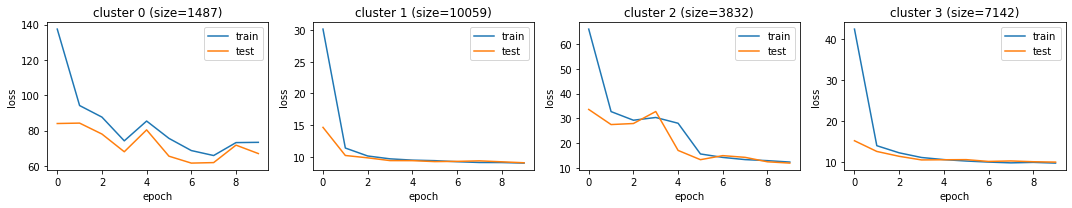

Relationa VAE results:{'f1_weighted': 0.4360123192381655, 'accuracy': 0.4912514432898126}


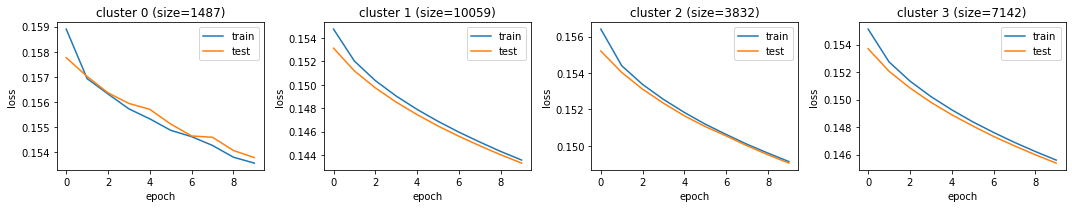

Relational DAE results:{'f1_weighted': 0.25953102275799844, 'accuracy': 0.3991473487876366}


In [ ]:
accuracies,f1s = cross_validation(X_train_tfidf,y_train_multiclass)

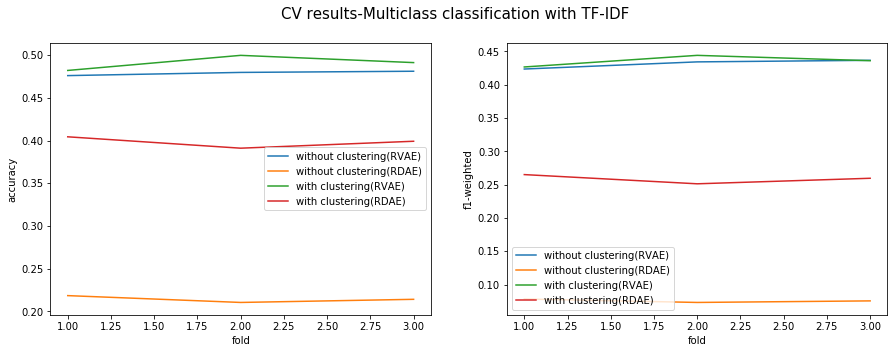

In [ ]:
plotCVResults(accuracies,f1s,'CV results-Multiclass classification with TF-IDF')

**Best result overall is the following:**

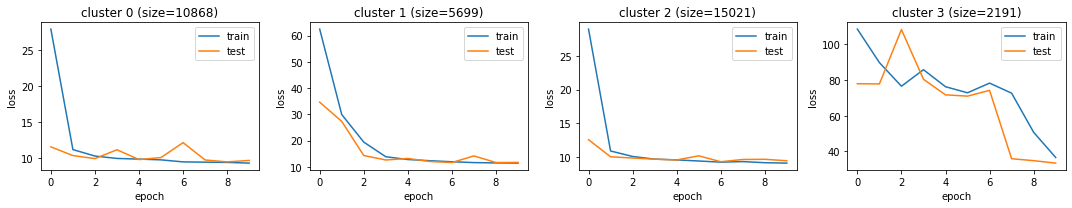

{'f1_weighted': 0.4695406025343885, 'accuracy': 0.516991297140489}


In [ ]:
clusters = getTrainTestDFsForEachCluster(X_train_tfidf,y_train_multiclass,X_test_tfidf,y_test_multiclass)
test_result = trainTestFlow(clusters,'variational',False)
print(test_result)

**Multi-label classification with TF-IDF**

Fold #1
without clustering
Relationa VAE results:{'f1_weighted': 0.34186453771260816, 'accuracy': 0.07326820603907638}
Relational DAE results:{'f1_weighted': 0.0, 'accuracy': 0.0}
with clustering


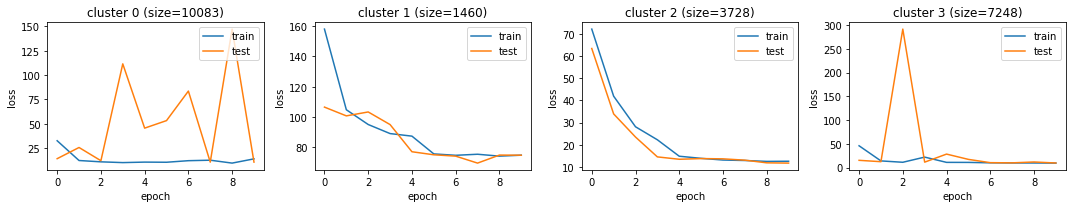

Relationa VAE results:{'f1_weighted': 0.34772081983320546, 'accuracy': 0.10550621669626999}


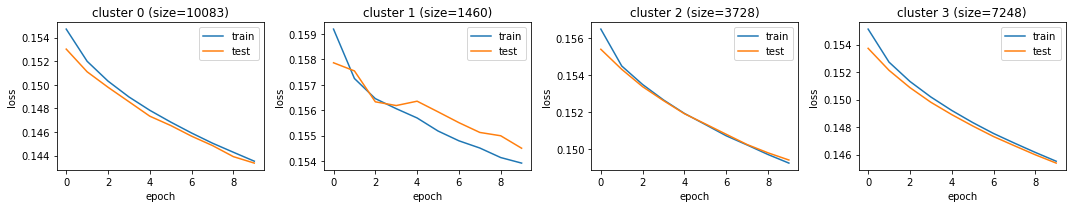

Relational DAE results:{'f1_weighted': 0.2894823823179899, 'accuracy': 0.06243339253996447}
Fold #2
without clustering
Relationa VAE results:{'f1_weighted': 0.3531329694689487, 'accuracy': 0.09005328596802842}
Relational DAE results:{'f1_weighted': 0.0, 'accuracy': 0.0}
with clustering


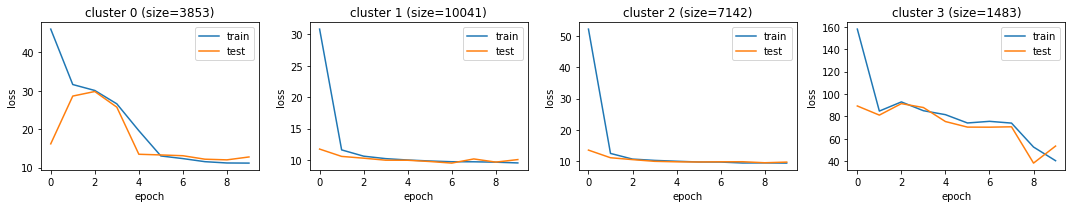

Relationa VAE results:{'f1_weighted': 0.38602268229183223, 'accuracy': 0.12282415630550622}


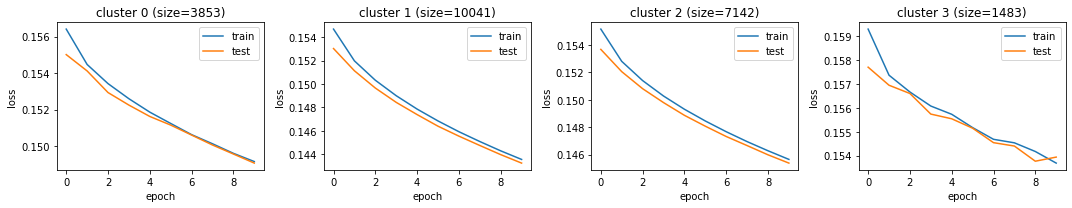

Relational DAE results:{'f1_weighted': 0.28418193014363724, 'accuracy': 0.06243339253996447}
Fold #3
without clustering
Relationa VAE results:{'f1_weighted': 0.3374208362991152, 'accuracy': 0.08268940403232969}
Relational DAE results:{'f1_weighted': 0.0, 'accuracy': 0.0}
with clustering


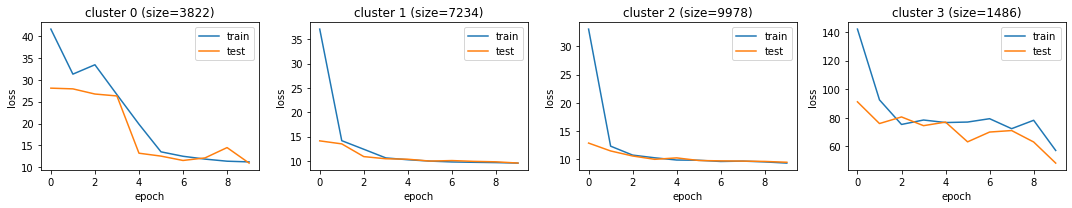

Relationa VAE results:{'f1_weighted': 0.38139973545393285, 'accuracy': 0.11333155697664091}


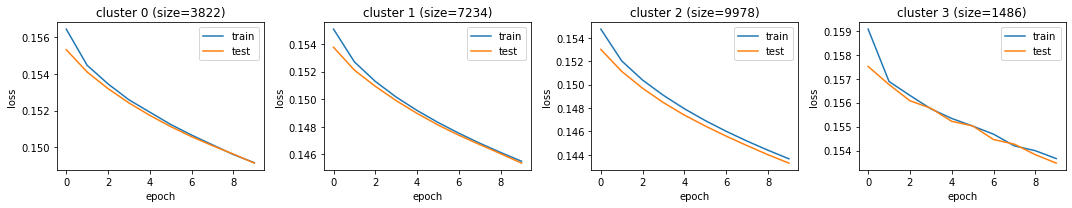

Relational DAE results:{'f1_weighted': 0.28562401565797313, 'accuracy': 0.06652455813127275}


In [ ]:
accuracies,f1s = cross_validation(X_train_tfidf,y_train_multilabel)

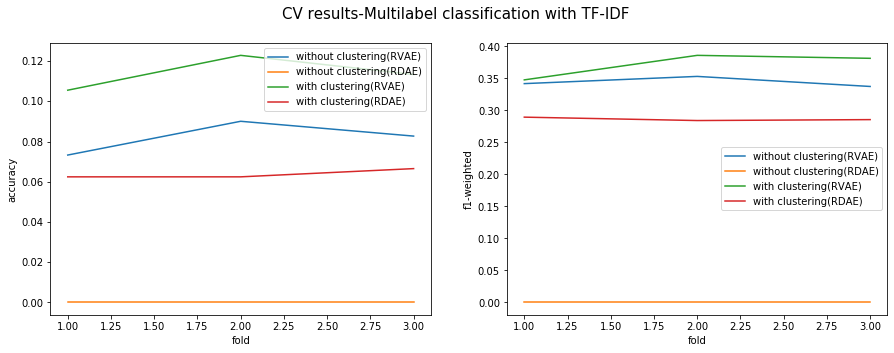

In [ ]:
plotCVResults(accuracies,f1s,'CV results-Multilabel classification with TF-IDF')

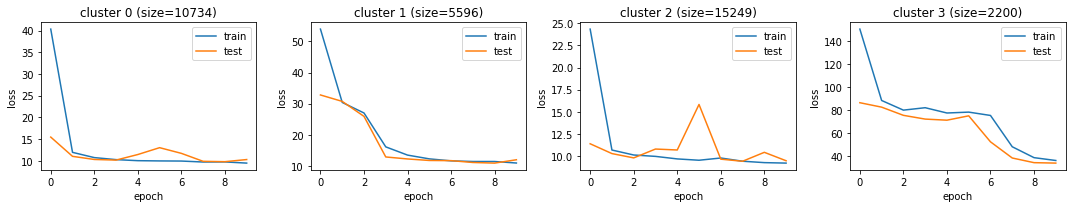

{'f1_weighted': 0.43648838352749597, 'accuracy': 0.15520099461251555}


In [ ]:
clusters = getTrainTestDFsForEachCluster(X_train_tfidf,y_train_multilabel,X_test_tfidf,y_test_multilabel)
test_result = trainTestFlow(clusters,'variational',False)
print(test_result)

**Multi-label classification with Word Embedding**

Fold #1
without clustering
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Relationa VAE results:{'f1_weighted': 0.38869573418833153, 'accuracy': 0.12246891651865009}
Relational DAE results:{'f1_weighted': 0.0, 'accuracy': 0.0}
with clustering


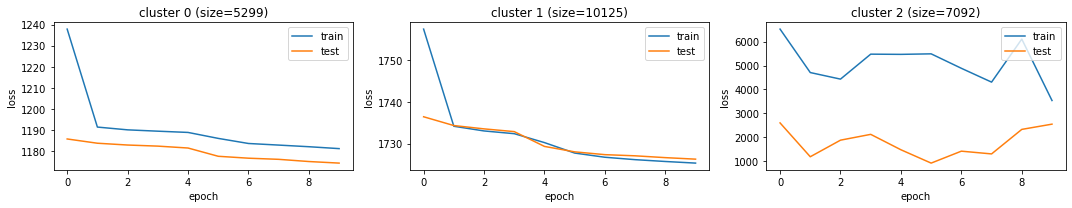

Relationa VAE results:{'f1_weighted': 0.36151007097654386, 'accuracy': 0.11287744227353463}


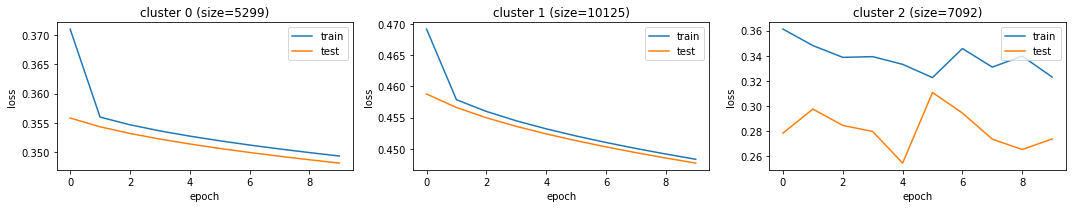

Relational DAE results:{'f1_weighted': 0.08653105272781442, 'accuracy': 0.0007104795737122557}
Fold #2
without clustering
Relationa VAE results:{'f1_weighted': 0.3774699091903655, 'accuracy': 0.11483126110124334}
Relational DAE results:{'f1_weighted': 0.0, 'accuracy': 0.0}
with clustering


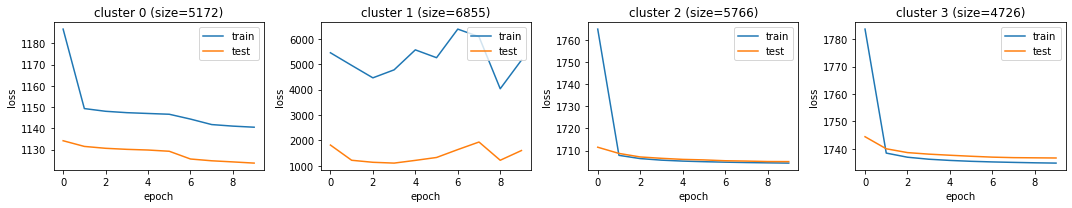

Relationa VAE results:{'f1_weighted': 0.33995075516317214, 'accuracy': 0.10746003552397869}


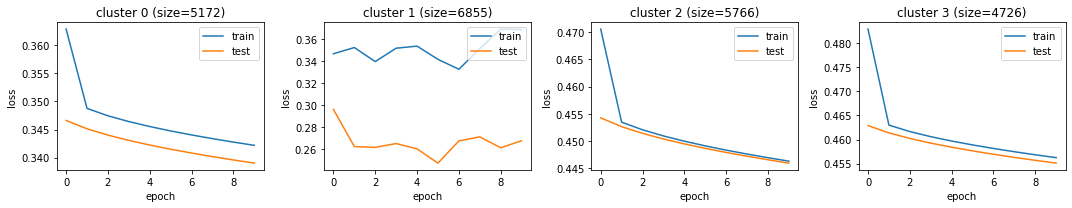

Relational DAE results:{'f1_weighted': 0.16742150209146628, 'accuracy': 0.0152753108348135}
Fold #3
without clustering
Relationa VAE results:{'f1_weighted': 0.37936935819990997, 'accuracy': 0.11821653788080647}
Relational DAE results:{'f1_weighted': 0.0, 'accuracy': 0.0}
with clustering


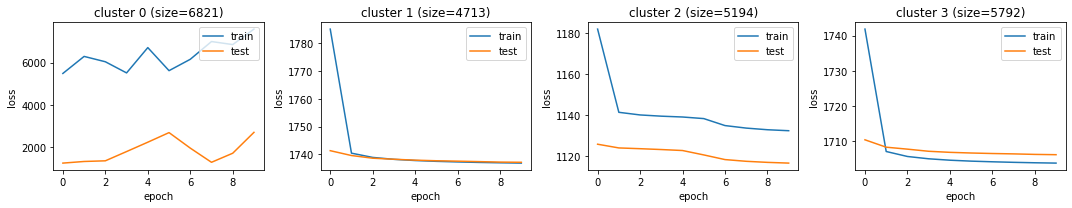

Relationa VAE results:{'f1_weighted': 0.3276495951576871, 'accuracy': 0.09947597477573497}


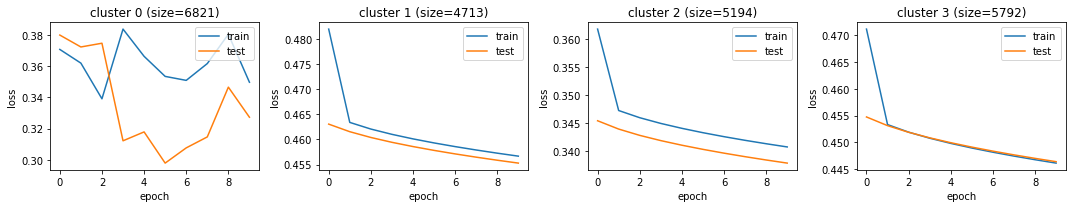

Relational DAE results:{'f1_weighted': 0.16841652148030853, 'accuracy': 0.017319477751132427}


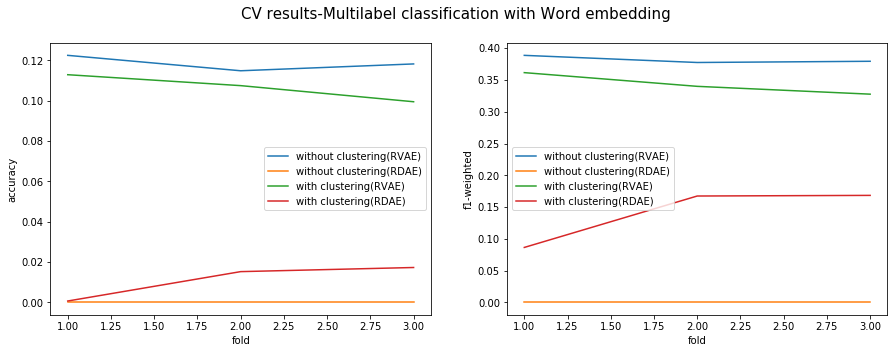

In [ ]:
accuracies,f1s = cross_validation(X_train_w2v,y_train_multilabel)
plotCVResults(accuracies,f1s,'CV results-Multilabel classification with Word embedding')

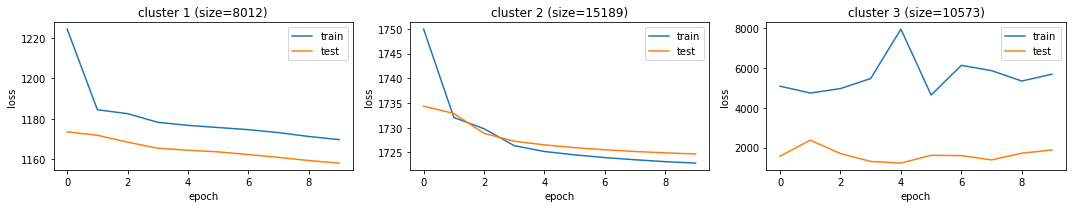

{'f1_weighted': 0.39612469002265677, 'accuracy': 0.13517060367454067}


In [ ]:
clusters = getTrainTestDFsForEachCluster(X_train_w2v,y_train_multilabel,X_test_w2v,y_test_multilabel)
test_result = trainTestFlow(clusters,'variational',False)
print(test_result)

#Results
**1.Multi-class classification achieves better scores compared to multi-label**
<br>
**2.Using TF-IDF gives the highest score among all cases**<br>
One of the reasons I suspect this happened is that I only used the first 130 words of each document based on the average number of words in each documet, thus the feature vector for lengthy documents is not a good representation of its content. But the "max_feature" of TF-IDF vectorizer automatically gets the most important words of the documents. <br>
Also, there are examples such as [this paper](https://ieeexplore.ieee.org/abstract/document/7259377) where TF-IDF has outperformed word embedding. (their proposed method outperforms both of them but in the baselines we can see that TF-IDF is better)<br>
**3.RVAE outperforms RDAE**<br>
I think it is dependant on the dataset. In the original paper, RDAE outperforms RVAE when used on CIFAR-10 dataset, so we can't conclude RDAE is not useful.<br>
**4.Classification with RDAE always improves with clustering significantly**<br>
**5.Classification with RVAE only improves when the text is represented with TF-IDF.**<br>
**6.L2 regularization doesn't improve word embedding results.**<br>
I initally tried to use L2 regularization regarding the results of [this paper](https://pdfs.semanticscholar.org/6bc3/ef19eec3ebbdb2ad81231062090e60c38c52.pdf) which said normalization will improve the performance. But after seeing the result this dataset without any improvement, I found out that L2 normalization is useful when we are calculating cosine similarity. But in this project, I didn't use cosine similarity in any of the steps, and the clustering in K-Means is done with Euclidean distance.<br>
**7.When using word embedding, the autoencoder in one of the clusters doesn't seem to learn anything**<br>
I think if more data was available to train these networks, the AEs would learn more useful features. According to VC shattering law, n number of samples is needed to learn n parameters. An AE with 7 hidden layers with near 1000 units in each layer needs more than around 8K (samples in each cluster) to learn meaningful features. Also, accourding to [this paper](https://arxiv.org/abs/1511.06348), deep nueral networks perform better with more data.







